In [10]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageOps,ImageFilter
import numpy as np
import keras
from keras import layers
import os
import numpy as np
#from keras.utils import Sequence
from tensorflow.keras import Sequential
import tensorflow as tf
import cv2


### View Image

In [12]:
image = PIL.Image.open("Dataset\images\\trainA\ct15.png")
image = image.resize((280,280))
image_array = np.array(image,dtype='float')
image_array = image_array.reshape(280,280,1)
image_array.shape,type(image_array)


((280, 280, 1), numpy.ndarray)

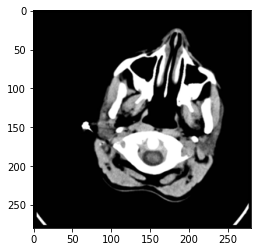

In [13]:
plt.imshow(image_array, cmap='gray')
plt.show()

In [14]:
import PIL
from PIL import Image,ImageOps
import numpy as np
image = Image.open("Dataset\\unseen_demo_images\mri\mri313.jpg")
image = ImageOps.grayscale(image)
image = image.resize((280,280))
image_array = np.array(image,dtype='float')
image_array = image_array.reshape(280,280,1)
image_array.shape,type(image_array)

((280, 280, 1), numpy.ndarray)

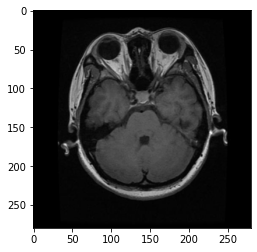

In [15]:
plt.imshow(image_array, cmap='gray')
plt.show()

Text(0.5, 1.0, 'Result')

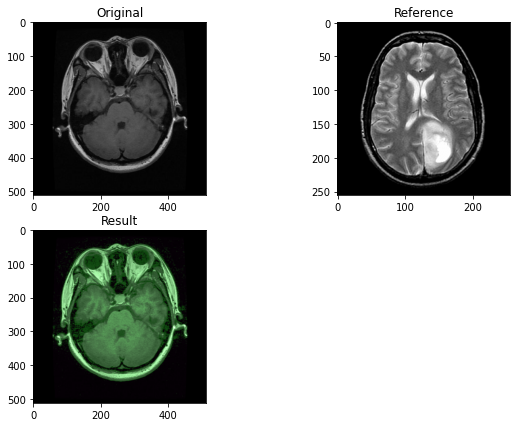

In [9]:
def hist_match(asli, referensi):

    asli_shape = asli.shape

    asli = asli.ravel()
    referensi = referensi.ravel()

    o_values, bin_idx, o_counts = np.unique(asli, return_inverse=True,return_counts=True)
    b_values, b_counts = np.unique(referensi, return_counts=True)

    o_quantiles = np.cumsum(o_counts).astype(np.float64)
    o_quantiles /= o_quantiles[-1]
    b_quantiles = np.cumsum(b_counts).astype(np.float64)
    b_quantiles /= b_quantiles[-1]

    interp_t_values = np.interp(o_quantiles, b_quantiles, b_values)

    return interp_t_values[bin_idx].reshape(asli_shape)



def histogram_matching(original,reference):
    asli = cv2.imread(original)
    equ = np.copy(asli)
    for i  in range (3) :
        equ[:,:,i] = cv2.equalizeHist(asli[:,:,i])
    referensi =  cv2.imread(reference)
    hasilmatch = np.copy(asli)
    hasilmatch[:,:,1] = hist_match(asli[:,:,1], referensi[:,:,1])
    return hasilmatch

new_img = histogram_matching("Dataset\\unseen_demo_images\mri\mri313.jpg","Dataset\images\ReferenceImage.png")
ori = plt.imread("Dataset\\unseen_demo_images\mri\mri313.jpg")
ref = plt.imread("Dataset\images\ReferenceImage.png")

fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)

plt.imshow(ori)
plt.title("Original")
  
fig.add_subplot(rows, columns, 2)

plt.imshow(ref)
plt.title("Reference")

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(new_img)
plt.title("Result")

### Image Preprocess

In [16]:
#loads images from a folder in np array form
def load_ct_from_folder(folder,n=500):
    images = []
    for filename in os.listdir(folder)[:n]:
        image = PIL.Image.open(os.path.join(folder,filename))
        image = image.resize((276,276))
        image_array = np.array(image,dtype='float')
        image_array = image_array.reshape(276,276,1)
        if image is not None:
            images.append(image_array)
    return np.array(images,dtype=float)

def load_mri_from_folder(folder,n=500):
    images = []
    for filename in os.listdir(folder)[:n]:
        image = Image.open(os.path.join(folder,filename))
        image = ImageOps.grayscale(image)
        image = image.filter(ImageFilter.SHARPEN)
        image = image.resize((276,276))
        image_array = np.array(image,dtype='float')
        image_array = image_array.reshape(276,276,1)
        if image is not None:
            images.append(image_array)
    return np.array(images,dtype=float)

In [17]:
x_train_A = load_ct_from_folder("Dataset\images\\trainA")
x_train_B = load_mri_from_folder("Dataset\images\\trainB")
x_test_A = load_ct_from_folder("Dataset\images\\testA")
x_test_B = load_mri_from_folder("Dataset\images\\testB")


In [18]:
np.save("x_train_A.npy",x_train_A)
np.save("x_train_B.npy",x_train_B)
np.save("x_test_A.npy",x_test_A)
np.save("x_test_B.npy",x_test_B)

KeyboardInterrupt: 

In [19]:
x_train_A = x_train_A.astype('float32') / 255.
x_train_B = x_train_B.astype('float32') / 255.
x_test_A = x_test_A.astype('float32') / 255.
x_test_B = x_test_B.astype('float32') / 255.

In [20]:
x_train_A.shape,x_train_B.shape,x_test_B.shape,x_test_B.shape

((500, 276, 276, 1),
 (500, 276, 276, 1),
 (500, 276, 276, 1),
 (500, 276, 276, 1))

### Designing the convolutional autoencoder

In [21]:
input_img = keras.Input(shape=(276, 276, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(None, 276, 276, 16)
(None, 138, 138, 16)
(None, 138, 138, 8)
(None, 69, 69, 8)
(None, 69, 69, 8)
(None, 35, 35, 8)
(None, 35, 35, 8)
(None, 70, 70, 8)
(None, 70, 70, 8)
(None, 140, 140, 8)
(None, 138, 138, 16)
(None, 276, 276, 16)
KerasTensor(type_spec=TensorSpec(shape=(None, 276, 276, 1), dtype=tf.float32, name=None), name='conv2d_6/Sigmoid:0', description="created by layer 'conv2d_6'")


### Training the autoencoder

In [22]:
history = autoencoder.fit(x_train_B, x_train_A,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_B, x_test_A))

Epoch 1/10
4/4 [==============================] - 109s 21s/step - loss: 0.6961 - val_loss: 0.6897
Epoch 2/10
4/4 [==============================] - 77s 20s/step - loss: 0.6882 - val_loss: 0.6819
Epoch 3/10
4/4 [==============================] - 75s 19s/step - loss: 0.6788 - val_loss: 0.6650
Epoch 4/10
4/4 [==============================] - 75s 19s/step - loss: 0.6582 - val_loss: 0.6337
Epoch 5/10
4/4 [==============================] - 73s 19s/step - loss: 0.6246 - val_loss: 0.6106
Epoch 6/10
4/4 [==============================] - 74s 19s/step - loss: 0.6076 - val_loss: 0.6013
Epoch 7/10
4/4 [==============================] - 70s 18s/step - loss: 0.5954 - val_loss: 0.5773
Epoch 8/10
4/4 [==============================] - 65s 17s/step - loss: 0.5705 - val_loss: 0.5586
Epoch 9/10
4/4 [==============================] - 63s 16s/step - loss: 0.5530 - val_loss: 0.5303
Epoch 10/10
4/4 [==============================] - 65s 16s/step - loss: 0.5219 - val_loss: 0.4970


In [23]:
autoencoder.save("autoencoderSharp.h5")
from keras.models import load_model
autoencoder=load_model("autoencoderSharp.h5")

### Testing the trained model and comparing it with the original data

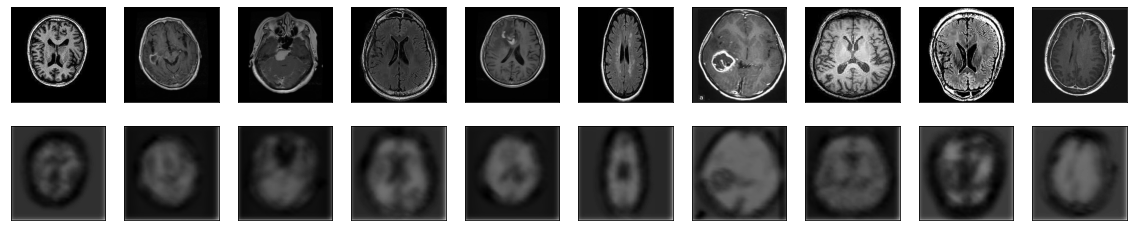

In [24]:
decoded_imgs = autoencoder.predict(x_test_B)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_B[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
unseen = load_ct_from_folder("Dataset\\unseen_demo_images\ct")

In [26]:
unseen_ct_imgs = autoencoder.predict(unseen)

In [27]:
unseen_ct_imgs.shape

(15, 276, 276, 1)

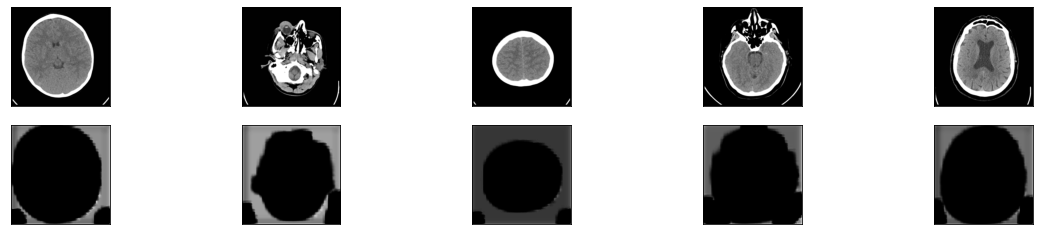

In [28]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(unseen[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(unseen_ct_imgs[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Visualising the states of a image through the autoencoder

In [43]:
#encoder model
model=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),activation ='relu', input_shape=(521,521,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(8,(3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(8,(3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),   
 ])

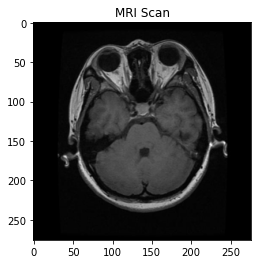

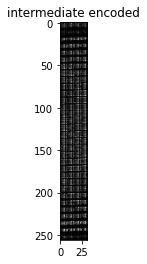

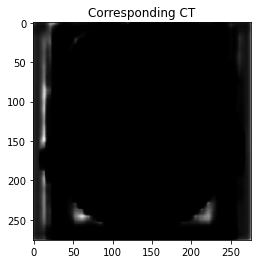

In [46]:
def visualize(img,encoder):
    code = encoder.predict(img[None])[0]
    
    # Display original
    plt.title("MRI Scan")
    plt.imshow(unseen[0].reshape(276, 276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    #Display compressed
    plt.subplot(1,3,2)
    plt.title("intermediate encoded")
    plt.imshow(code.reshape([code.shape[-1]//32,-1]))
    plt.show()

    # Display reconstruction
    plt.title("Corresponding CT")
    plt.imshow(unseen_ct_imgs[0].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

visualize(x_test_B[0],model)

### Analysing the loss wrt epoch

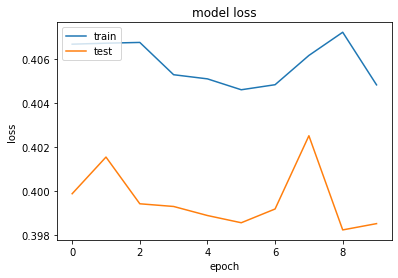

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()